## Pré configurações 

In [ ]:
!pwd

In [ ]:
!ls

In [ ]:
#precisa instala alguns pacotes.

#NO MAC
'''
brew install tcl-tk
pip install lxml
brew install protobuf
brew install pil




'''

# For CPU
!pip install tensorflow
# For GPU
!pip install tensorflow-gpu
!pip install --user Cython
!pip install --user contextlib2
!pip install lxml
!pip install PIL

!pip install --user Cython
!pip install --user contextlib2
!pip install --user pillow
!pip install --user lxml


In [ ]:
#Precisa configurar o COCOAPI
!git clone https://github.com/cocodataset/cocoapi.git

In [ ]:
!ls

In [ ]:
!cd cocoapi/PythonAPI
!make


In [ ]:
!pwd

In [ ]:
#parece que ele precisa links direto para o folder onde está as funcoes da COCOAPI
!cp object_detection_tutorial.ipynb  /Users/arnaldoljr/.virtualenvs/cv/lib/python3.7/site-packages/tensorflow/models/research/object_detection/

In [ ]:
#Obs para configurar 
# https://github.com/tensorflow/models/issues/1962 
# From tensorflow/models/research/
# !export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim
 # # From tensorflow/models/research/
#  protoc object_detection/protos/*.proto --python_out=.           
            

# Imports

In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
    raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')


## Env setup

In [2]:
# This is needed to display the images.
%matplotlib inline

## Object detection imports
Here are the imports from the object detection module.

In [3]:
!pwd

/Users/arnaldoljr/.virtualenvs/cv/lib/python3.7/site-packages/tensorflow/models/research/object_detection


In [4]:
#tem que carregar da pasta correta...

from utils import label_map_util

from utils import visualization_utils as vis_util

# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [5]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

## Download Model

In [6]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [7]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [9]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [21]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(2, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [22]:
def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
          # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in ['num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks']:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                      tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                      tensor_name)
            if 'detection_masks' in tensor_dict:
                    # The following processing is only for single image
                    detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                    detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                    # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                    real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                    detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                    detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                    detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                        detection_masks, detection_boxes, image.shape[0], image.shape[1])
                    detection_masks_reframed = tf.cast(
                        tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                    # Follow the convention by adding back the batch dimension
                    tensor_dict['detection_masks'] = tf.expand_dims(
                        detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

             # Run inference
            output_dict = sess.run(tensor_dict,feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict['detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
        return output_dict

Coordenadas dections boxes: 
 [[5.5387682e-01 3.9422381e-01 5.9312469e-01 4.0913767e-01]
 [3.8294643e-01 3.4582412e-01 4.0220094e-01 3.5902989e-01]
 [5.7416666e-01 5.7667006e-02 6.2335181e-01 7.4753799e-02]
 [7.9914421e-02 4.3740910e-01 1.6590245e-01 5.0060284e-01]
 [2.6564282e-01 2.0112292e-01 3.0753511e-01 2.2309385e-01]
 [6.8338084e-01 7.8429937e-02 8.4058809e-01 1.1782578e-01]
 [3.8510028e-01 4.3172216e-01 4.0073249e-01 4.4773054e-01]
 [7.6061964e-01 1.5739655e-01 9.3692541e-01 2.0186904e-01]
 [5.4281253e-01 2.5604743e-01 5.6234604e-01 2.6740867e-01]
 [5.8708113e-01 2.6993144e-02 6.2043804e-01 4.1338023e-02]
 [5.9907246e-01 1.3398451e-01 6.2281477e-01 1.4569619e-01]
 [2.6699686e-01 2.0941132e-01 3.0930108e-01 2.3242617e-01]
 [3.8655984e-01 4.2660943e-01 4.0327263e-01 4.3934646e-01]
 [5.6642860e-01 6.1350901e-02 5.9360904e-01 7.1110524e-02]
 [4.4279569e-01 7.9928982e-01 4.8113447e-01 8.2094431e-01]
 [3.8146478e-01 3.4821925e-01 3.8997090e-01 3.5682747e-01]
 [5.6562024e-01 6.0473460e

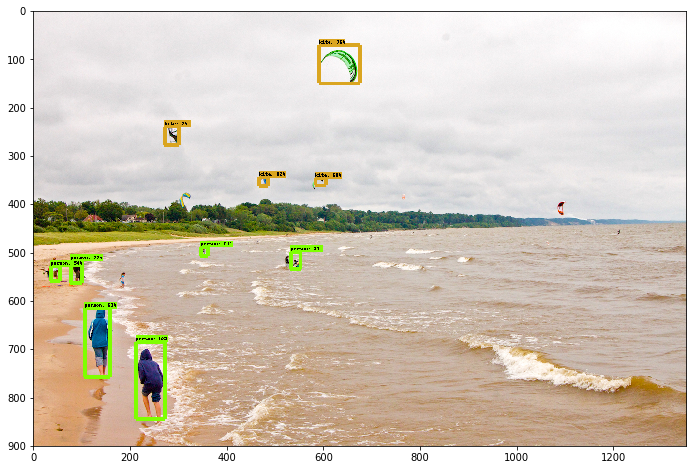

In [23]:
%matplotlib inline
for image_path in TEST_IMAGE_PATHS:
    image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE) 
    plt.imshow(image_np)
    plt.savefig("detec.png")
        
    #'''
    
    
    print('Coordenadas dections boxes: \n',output_dict['detection_boxes'],'\n',
          'Classes Coordenadas: \n', output_dict['detection_classes'],'\n', 
          'Scores detectados: \n',output_dict['detection_scores'],'\n',
          'Indices das categorias: \n',category_index,'\n',
          'Máscaras Dectadas: \n',output_dict.get('detection_masks'),'\n')
    
    
    
    #'''
    
    #escrevendo informações no arquivo textoTODAS AS INFORMACOE'

    '''
    Coordenadasboxes= output_dict['detection_boxes'] 
    ClassesCoordenadas =  output_dict['detection_classes'] 
    Scoresdetectados = output_dict['detection_scores'] 
    Indcateg = category_index
    with open('arq1.txt','a') as arq:
        arq.write("Coordenadas dections boxes: {} \n".format(Coordenadasboxes)+"\n")
        
        arq.write("Classes Coordenadas: {} \n".format(ClassesCoordenadas) +"\n")
        arq.write("Scores detectados: {} \n".format(Scoresdetectados)+"\n")
        arq.write("Índices de Categorias: {} \n".format(Indcateg)+"\n")
    
    arq.close()
   '''
    
    #analisando informacoes específicas 
    '''
    print('\n\nCoordenadas dections boxes: \n\n',output_dict['detection_boxes'][0],'\n',
          '\n\nClasses Coordenadas: \n', output_dict['detection_classes'][0],'\n', 
          '\n\nScores detectados: \n',output_dict['detection_scores'][0],'\n',
          '\n\nIndices das categorias: \n',category_index,'\n',
          '\n\nMáscaras Dectadas: \n',output_dict.get('detection_masks'),'\n')
    '''
    '''
    #alocando variaveis para escrever no arquivo texto
    Coord_dections_boxes = output_dict['detection_boxes'][0]
    Classes_Coordenadas =  output_dict['detection_classes'][0]
    Scores_detectados = output_dict['detection_scores'][0]
    Ind_cat =  category_index 
    Msc_Dect = output_dict.get('detection_masks') 
    
    
    
    
    #escrevendo no arquivos texto as informações específicas 
    with open('arq2.txt','a') as arq2:
        arq2.write("Coordenadas dections boxesFINAL: \n {}".format(Coord_dections_boxes) + "\n")
        arq2.write("Classes CoordenadasFINAL: \n {} ".format(Classes_Coordenadas)+"\n")
        arq2.write("Scores detectadosFINAL: \n {} ".format(Scores_detectados)+"\n")
        arq2.write("Índices de CategoriasFINAL: \n {} ".format(Ind_cat)+"\n")
        arq2.write("Máscaras das dect: \n {} ".format(Msc_Dect)+"\n")
    arq2.close
    '''

In [24]:
print('Coordenadas dections boxes: \n',output_dict['detection_boxes'],'\n',
          'Classes Coordenadas: \n', output_dict['detection_classes'],'\n', 
          'Scores detectados: \n',output_dict['detection_scores'],'\n',
          'Indices das categorias: \n',category_index,'\n',
          'Máscaras Dectadas: \n',output_dict.get('detection_masks'),'\n')
    

Coordenadas dections boxes: 
 [[5.5387682e-01 3.9422381e-01 5.9312469e-01 4.0913767e-01]
 [3.8294643e-01 3.4582412e-01 4.0220094e-01 3.5902989e-01]
 [5.7416666e-01 5.7667006e-02 6.2335181e-01 7.4753799e-02]
 [7.9914421e-02 4.3740910e-01 1.6590245e-01 5.0060284e-01]
 [2.6564282e-01 2.0112292e-01 3.0753511e-01 2.2309385e-01]
 [6.8338084e-01 7.8429937e-02 8.4058809e-01 1.1782578e-01]
 [3.8510028e-01 4.3172216e-01 4.0073249e-01 4.4773054e-01]
 [7.6061964e-01 1.5739655e-01 9.3692541e-01 2.0186904e-01]
 [5.4281253e-01 2.5604743e-01 5.6234604e-01 2.6740867e-01]
 [5.8708113e-01 2.6993144e-02 6.2043804e-01 4.1338023e-02]
 [5.9907246e-01 1.3398451e-01 6.2281477e-01 1.4569619e-01]
 [2.6699686e-01 2.0941132e-01 3.0930108e-01 2.3242617e-01]
 [3.8655984e-01 4.2660943e-01 4.0327263e-01 4.3934646e-01]
 [5.6642860e-01 6.1350901e-02 5.9360904e-01 7.1110524e-02]
 [4.4279569e-01 7.9928982e-01 4.8113447e-01 8.2094431e-01]
 [3.8146478e-01 3.4821925e-01 3.8997090e-01 3.5682747e-01]
 [5.6562024e-01 6.0473460e

In [14]:
print(output_dict)

{'num_detections': 100, 'detection_boxes': array([[3.90839875e-02, 1.92150474e-02, 8.72103572e-01, 3.15773487e-01],
       [1.09515011e-01, 4.02835608e-01, 9.24646080e-01, 9.73047853e-01],
       [5.07123828e-01, 3.85651529e-01, 8.76479626e-01, 7.03940928e-01],
       [6.38730824e-02, 2.81166792e-01, 9.16385174e-01, 8.24097395e-01],
       [2.15276688e-01, 3.96741033e-01, 9.12904143e-01, 6.79073691e-01],
       [5.27002275e-01, 3.72713268e-01, 8.83502781e-01, 6.94296658e-01],
       [0.00000000e+00, 5.25425553e-01, 2.53364921e-01, 7.16124296e-01],
       [7.37803876e-02, 2.98964173e-01, 9.20516372e-01, 9.38026905e-01],
       [5.31044006e-01, 3.84130061e-01, 9.15436625e-01, 8.53949249e-01],
       [1.45327598e-01, 3.87902349e-01, 9.06316280e-01, 9.78849053e-01],
       [2.08420575e-01, 2.78770030e-01, 8.26955020e-01, 6.09079659e-01],
       [3.48854035e-01, 3.05225760e-01, 8.99384618e-01, 7.33767033e-01],
       [7.35032558e-03, 5.13690710e-02, 6.02022588e-01, 8.20265889e-01],
       [

In [15]:
import pprint
pprint.pprint(output_dict)

{'detection_boxes': array([[3.90839875e-02, 1.92150474e-02, 8.72103572e-01, 3.15773487e-01],
       [1.09515011e-01, 4.02835608e-01, 9.24646080e-01, 9.73047853e-01],
       [5.07123828e-01, 3.85651529e-01, 8.76479626e-01, 7.03940928e-01],
       [6.38730824e-02, 2.81166792e-01, 9.16385174e-01, 8.24097395e-01],
       [2.15276688e-01, 3.96741033e-01, 9.12904143e-01, 6.79073691e-01],
       [5.27002275e-01, 3.72713268e-01, 8.83502781e-01, 6.94296658e-01],
       [0.00000000e+00, 5.25425553e-01, 2.53364921e-01, 7.16124296e-01],
       [7.37803876e-02, 2.98964173e-01, 9.20516372e-01, 9.38026905e-01],
       [5.31044006e-01, 3.84130061e-01, 9.15436625e-01, 8.53949249e-01],
       [1.45327598e-01, 3.87902349e-01, 9.06316280e-01, 9.78849053e-01],
       [2.08420575e-01, 2.78770030e-01, 8.26955020e-01, 6.09079659e-01],
       [3.48854035e-01, 3.05225760e-01, 8.99384618e-01, 7.33767033e-01],
       [7.35032558e-03, 5.13690710e-02, 6.02022588e-01, 8.20265889e-01],
       [7.01455474e-02, 4.42671

In [13]:
print(output_dict['detection_scores'][0])

0.9406908


In [18]:
#teste com a imagem dos cachorros OK
#tam = len(output_dict['detection_boxes'])
data = {}
i=0
while ((output_dict['detection_scores'][i]) > 0.49999):
    chave = output_dict['detection_classes'][i]
    #print((output_dict['detection_scores'][i]))
    data.setdefault(chave,[]).append(output_dict['detection_scores'][i])
    i+=1
    

print(data)    

    
    

{18: [0.9406908, 0.9345027]}


In [25]:
#teste com a imagem dos kites OK
#tam = len(output_dict['detection_boxes'])
data = {}
i=0
while ((output_dict['detection_scores'][i]) > 0.49999):
    chave = output_dict['detection_classes'][i]
    #print((output_dict['detection_scores'][i]))
    data.setdefault(chave,[]).append(output_dict['detection_scores'][i])
    i+=1
    

print(data)    

    
    

{1: [0.91687834, 0.77850544, 0.63423437, 0.5891017, 0.5123768, 0.50146383], 38: [0.82944524, 0.7699847, 0.7555386, 0.60740656]}


In [ ]:
#testes jogar informações dentro de um txt


In [ ]:
%matplotlib inline
for image_path in TEST_IMAGE_PATHS:
    #teste1
    image = Image.open(image_path)
    #image_np = Image.open(image_path)
    image_np = load_image_into_numpy_array(image)


    #image = Image.open(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    #testeExtracInfo
    with detection_graph.as_default():
        config = tf.ConfigProto(log_device_placement=False)
        config.gpu_options.allow_growth = False
        with tf.Session(graph=detection_graph, config=config) as sess:
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
            detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')


            #ret, image_np = cap.read()
            image_np_expanded = np.expand_dims(image_np, axis=0)

            (boxes, scores, classes, num) = sess.run([detection_boxes, detection_scores, detection_classes, num_detections],
                  feed_dict={image_tensor: image_np_expanded})

            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.squeeze(boxes),
                np.squeeze(classes).astype(np.int32),
                np.squeeze(scores),
                category_index,
                use_normalized_coordinates=True,
                line_thickness=10)

        #image_np = load_image_into_numpy_array(image)
        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        #image_np_expanded = np.expand_dims(image_np, axis=0)
        # Actual detection.
        #output_dict = run_inference_for_single_image(image_np, detection_graph)
        # Visualization of the results of a detection.
        '''
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            line_thickness=8)
        '''
        plt.figure(figsize=IMAGE_SIZE) 
        plt.imshow(image_np)
        plt.savefig("detec2.png")

        '''
    print('Coordenadas dections boxes: \n',output_dict['detection_boxes'],'\n',
          'Classes Coordenadas: \n', output_dict['detection_classes'],'\n', 
          'Scores detectados: \n',output_dict['detection_scores'],'\n',
          'Indices das categorias: \n',category_index,'\n',
          'Máscaras Dectadas: \n',output_dict.get('detection_masks'),'\n')
    '''
    
    #escrevendo informações no arquivo textoTODAS AS INFORMACOE'

    '''
    Coordenadasboxes= output_dict['detection_boxes'] 
    ClassesCoordenadas =  output_dict['detection_classes'] 
    Scoresdetectados = output_dict['detection_scores'] 
    Indcateg = category_index
    with open('arq1.txt','a') as arq:
        arq.write("Coordenadas dections boxes: {} \n".format(Coordenadasboxes)+"\n")
        
        arq.write("Classes Coordenadas: {} \n".format(ClassesCoordenadas) +"\n")
        arq.write("Scores detectados: {} \n".format(Scoresdetectados)+"\n")
        arq.write("Índices de Categorias: {} \n".format(Indcateg)+"\n")
    
    arq.close()
   '''
    
    #analisando informacoes específicas 
    '''
    print('\n\nCoordenadas dections boxes: \n\n',output_dict['detection_boxes'][0],'\n',
          '\n\nClasses Coordenadas: \n', output_dict['detection_classes'][0],'\n', 
          '\n\nScores detectados: \n',output_dict['detection_scores'][0],'\n',
          '\n\nIndices das categorias: \n',category_index,'\n',
          '\n\nMáscaras Dectadas: \n',output_dict.get('detection_masks'),'\n')
    '''
    '''
    #alocando variaveis para escrever no arquivo texto
    Coord_dections_boxes = output_dict['detection_boxes'][0]
    Classes_Coordenadas =  output_dict['detection_classes'][0]
    Scores_detectados = output_dict['detection_scores'][0]
    Ind_cat =  category_index 
    Msc_Dect = output_dict.get('detection_masks') 
    
    
    
    
    #escrevendo no arquivos texto as informações específicas 
    with open('arq2.txt','a') as arq2:
        arq2.write("Coordenadas dections boxesFINAL: \n {}".format(Coord_dections_boxes) + "\n")
        arq2.write("Classes CoordenadasFINAL: \n {} ".format(Classes_Coordenadas)+"\n")
        arq2.write("Scores detectadosFINAL: \n {} ".format(Scores_detectados)+"\n")
        arq2.write("Índices de CategoriasFINAL: \n {} ".format(Ind_cat)+"\n")
        arq2.write("Máscaras das dect: \n {} ".format(Msc_Dect)+"\n")
    arq2.close
    '''

In [ ]:
final_score = np.squeeze(scores)    
count = 0
for i in range(100):
    if scores is None or final_score[i] > 0.5:
        count = count + 1

In [ ]:
count

In [ ]:
final_score = np.squeeze(scores)    


In [ ]:
print(len(boxes.shape))


In [ ]:
len(final_score)

O campo detection scores expõe quantos objetos ele identificou na imagem. Sempre ordenado do maior para o menor, os campos maiores que 0.5 indicam quantos objectos foram coletados pela imagem.

In [ ]:
print(output_dict)

In [ ]:
print(output_dict.get('detection_masks'))

In [ ]:
print(output_dict['num_detections']) 

In [ ]:
print(output_dict['detection_boxes'][0])